# 3.2 クラス編成

1. 学年の全生徒をそれぞれ1つのクラスに割り当てる
2. 各クラスの生徒の人数は39人以上、40人以下とする（318人の生徒がいて8つのクラスに分ける）
3. 各クラスの男子、女子の人数は20人以下とする（男子158人、女子160人）
4. 各クラスの学力試験の平均点は、学年平均±10点とする（500点満点で学年平均は303.6点）
5. 各クラスにリーダー気質の生徒を2人以上割り当てる（リーダー気質の生徒は17人いる）
6. 特別な支援が必要な生徒は各クラスに1人以下とする（計4人いる）
7. 特定ペアの生徒は同一クラスに割り当てない（3組いる）

   student_id  gender  leader_flag  support_flag  score
0           1       0            0             0    335
1           2       1            0             0    379
2           3       0            0             0    350
3           4       0            0             0    301
4           5       1            0             0    317
1 318
0    160
1    158
Name: gender, dtype: int64
count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64
0    301
1     17
Name: leader_flag, dtype: int64
0    314
1      4
Name: support_flag, dtype: int64


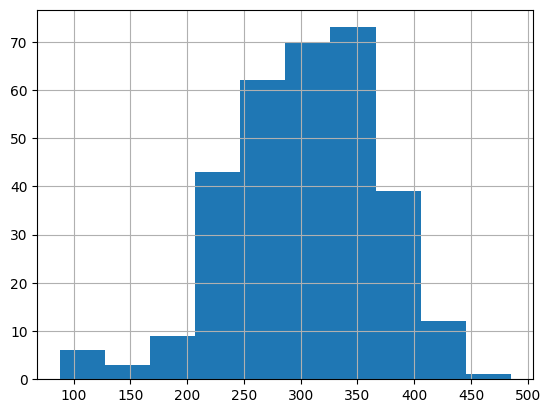

In [12]:
import pandas as pd
s_df = pd.read_csv("data/students.csv")
print(s_df.head())
print(s_df["student_id"].min(), s_df["student_id"].max())
print(s_df["gender"].value_counts())
print(s_df["score"].describe())
s_df["score"].hist()
print(s_df["leader_flag"].value_counts())
print(s_df["support_flag"].value_counts())

In [13]:
s_pair_df = pd.read_csv("data/student_pairs.csv")
s_pair_df

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [26]:
import pulp

prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)  # この問題では目的関数は定めないが

# 生徒のリスト
S = s_df["student_id"].tolist()
# クラスのリスト
C = ["A", "B", "C", "D", "E", "F", "G", "H"]  # 本来ハードコーディングは望ましくない
# 生徒とクラスのペアのリスト（取りうる全組み合わせ318人×8クラス＝2544通り）
SC = [(s, c) for s in S for c in C]

# 生徒をどのクラスに割り当てるかを変数として定義
x = pulp.LpVariable.dicts("x", SC, cat="Binary")
# 第2引数は変数の添え字のリスト

# 1. 各生徒は1つのクラスに割り当たる
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1

# 2. 各クラスの生徒の人数は39人以上40人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <= 40

# 男子生徒のリスト
S_male = s_df.loc[s_df["gender"] == 1, "student_id"].tolist()
# 女子生徒のリスト
S_female = s_df.loc[s_df["gender"] == 0, "student_id"].tolist()
# 3. 各クラスの男子、女子の人数は20人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = s_df.set_index("student_id").to_dict()["score"]
# 平均点の算出
score_mean = s_df["score"].mean()
# 4. 各クラスの学力試験の平均点は学年平均±10点とする
# score_mean - 10 <= クラスのスコア合計÷クラスの人数
# クラスのスコア合計÷クラスの人数 <= score_mean + 10
# をそれぞれ通分する。
for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) <= pulp.lpSum([x[s, c] * score[s] for s in S])
    prob += pulp.lpSum([x[s, c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

# リーダー気質の生徒の集合
S_leader = s_df.loc[s_df["leader_flag"] == 1, "student_id"].tolist()
# 5. 各クラスにリーダー気質の生徒を2人以上割り当てる
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = s_df.loc[s_df["support_flag"] == 1, "student_id"].tolist()
# 6. 特別な支援が必要な生徒は各クラスに1人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

# 7. 特別ペアの生徒は同一クラスに割り当てない
for s in s_pair_df.itertuples():
    for c in C:
        prob += x[s.student_id1, c] + x[s.student_id2, c] <= 1

status = prob.solve(pulp.PULP_CBC_CMD(msg=0))
print(status)  # 1 = Optimal


1


In [28]:
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]

for c, Ss in C2Ss.items():
    print("Class:", c)
    print("Num:", len(Ss))
    print("Student:", Ss)
    print()

Class: A
Num: 40
Student: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 237, 240, 246, 264, 267, 291, 292, 298]

Class: B
Num: 40
Student: [11, 15, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 124, 127, 146, 149, 159, 167, 170, 172, 176, 188, 190, 203, 212, 213, 220, 222, 231, 238, 245, 263, 270, 275, 276, 283, 287, 290, 317]

Class: C
Num: 40
Student: [3, 10, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 122, 142, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 277, 278, 301, 318]

Class: D
Num: 40
Student: [13, 16, 36, 37, 43, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 121, 128, 134, 139, 140, 158, 161, 175, 192, 198, 200, 205, 218, 221, 225, 235, 241, 252, 255, 256, 257, 261, 266, 293, 316]

Class: E
Num: 40
Student: [5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 107, 115, 129, 132, 141, 143, 150, 154, 164, 166, 183, 184, 189, 19

### 3.4 数理モデルの検証

In [35]:
# 1. 学年の全生徒をそれぞれ1つのクラスに割り当てる
lst_assigned_class = []
for s in S:
    assigned_class = [c for c in C if x[s, c].value() == 1]
    if len(assigned_class) != 1:
        print("error:", s, assigned_class)
    else:
        lst_assigned_class.append(assigned_class[0])

In [37]:
# 2. 各クラスの生徒の人数は39人以上40人以下とする
result_df = s_df.copy()
result_df["assigned_class"] = lst_assigned_class
result_df.groupby("assigned_class")["student_id"].count()

assigned_class
A    40
B    40
C    40
D    40
E    40
F    39
G    40
H    39
Name: student_id, dtype: int64

In [38]:
# 3. 各クラスの男子と女子の人数はそれぞれ20人以下とする
result_df.groupby(["assigned_class", "gender"])["student_id"].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         20
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         19
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [39]:
# 4. 各クラスの学力試験の平均点は学年平均±10点以内とする。
result_df.groupby("assigned_class")["score"].mean() - result_df["score"].mean()

assigned_class
A    9.755346
B   -9.169654
C    8.355346
D    6.855346
E   -6.869654
F   -8.260039
G    8.605346
H   -9.721577
Name: score, dtype: float64

In [40]:
# 5. 各クラスにリーダー気質の生徒を2人以上割り当てる。
result_df.groupby("assigned_class")["leader_flag"].sum()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [42]:
# 特別な支援が必要な生徒は各クラスに1人以下とする
result_df.groupby("assigned_class")["support_flag"].sum()

assigned_class
A    0
B    1
C    1
D    0
E    1
F    0
G    1
H    0
Name: support_flag, dtype: int64

In [49]:
# 7. 特定ペアの生徒は同一クラスに割り当てない
for s in s_pair_df.itertuples():
    c1 = result_df.loc[result_df["student_id"] == s.student_id1, "assigned_class"].tolist()[0]
    c2 = result_df.loc[result_df["student_id"] == s.student_id2, "assigned_class"].tolist()[0]
    print(f"student:{s.student_id1} is in class:{c1}, student:{s.student_id2} is in class:{c2}")

student:118 is in class:G, student:189 is in class:E
student:72 is in class:E, student:50 is in class:B
student:314 is in class:H, student:233 is in class:A


### 各クラスのテストスコアの分布確認

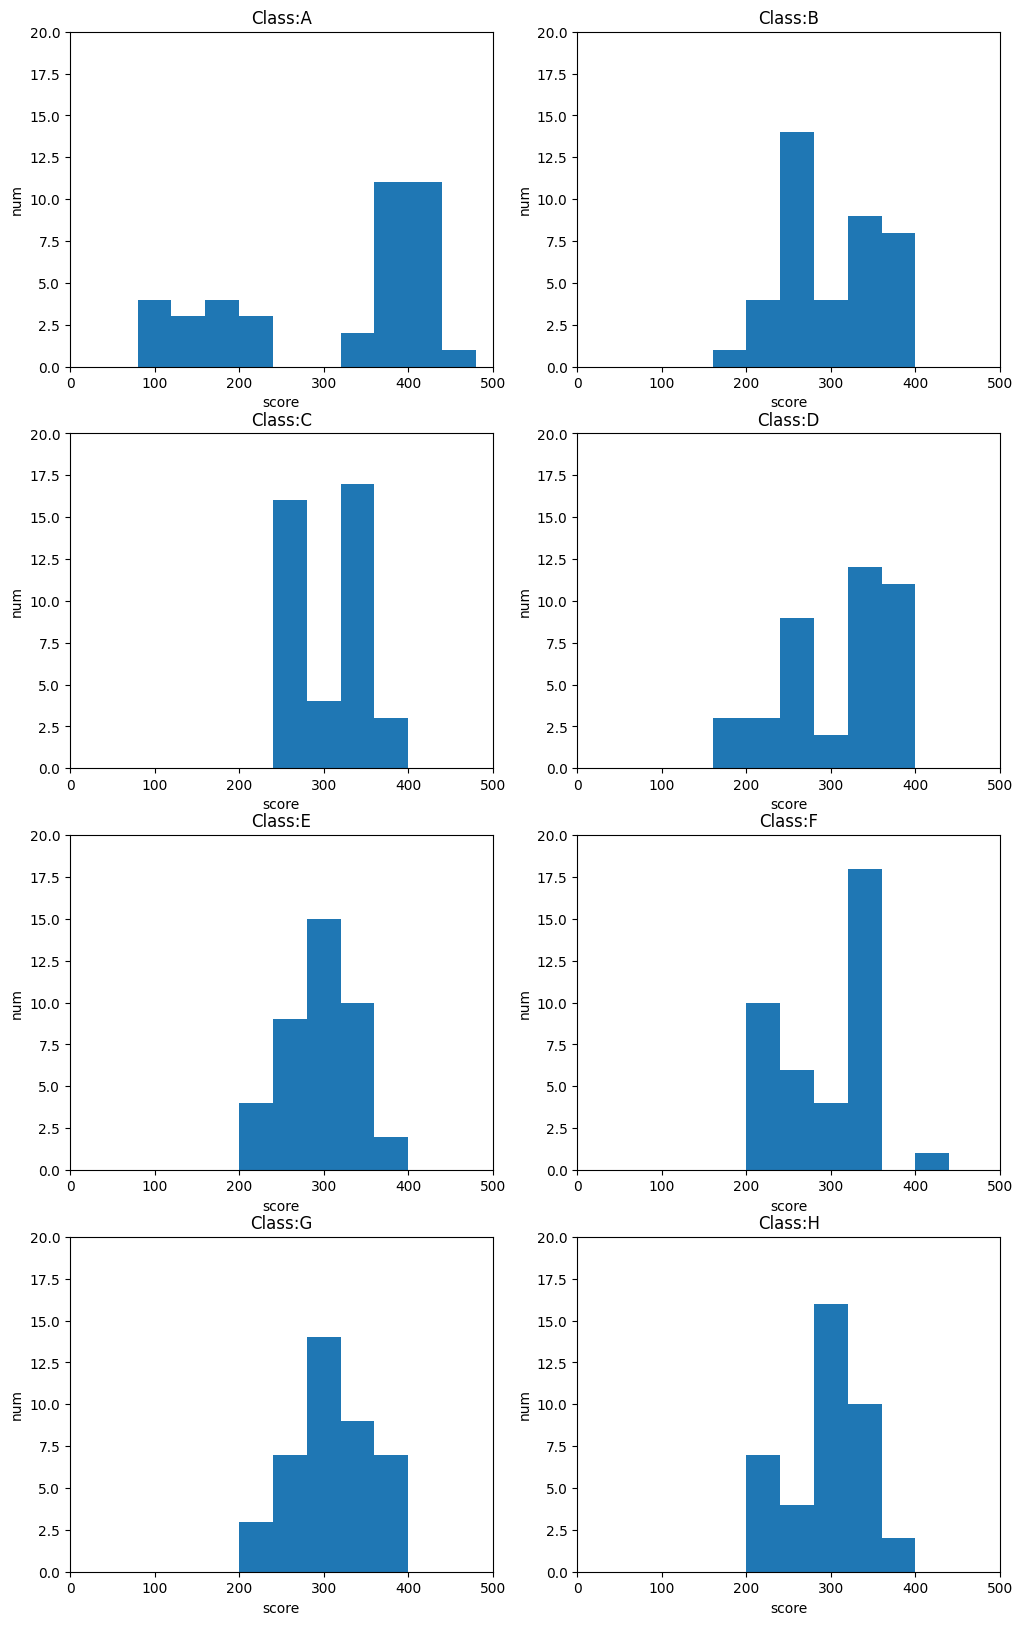

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(C):
    cls_df = result_df.loc[result_df["assigned_class"] == c, :]
    ax = fig.add_subplot(4, 2, i + 1, xlabel="score", ylabel="num", xlim=(0, 500), ylim=(0, 20),
                         title=f"Class:{c}")
    ax.hist(cls_df["score"], bins=range(0, 500, 40))

上図のように、クラスごとの成績の分布がバラバラとなっているのは望ましくない。

実際の人手のクラス編成では、初めに学力順に生徒を各クラスに割り当て、
この初期割り当てをできるだけ保ちつつ、その他の条件を満たすようにクラスを編成していく。
そこで、この考え方を取り入れることを考える。

In [53]:
# 初期クラス編成のデータを作成
# 学食をもとに順位を付与
s_df["score_rank"] = s_df["score"].rank(ascending=False, method="first")

# 学力順にクラス編成する
class_dic = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H"}
s_df["init_assigned_class"] = s_df["score_rank"].map(lambda x: x % 8).map(class_dic)

In [56]:
# init_flagを作成
init_flag = {(s, c): 0 for s, c in SC}
for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

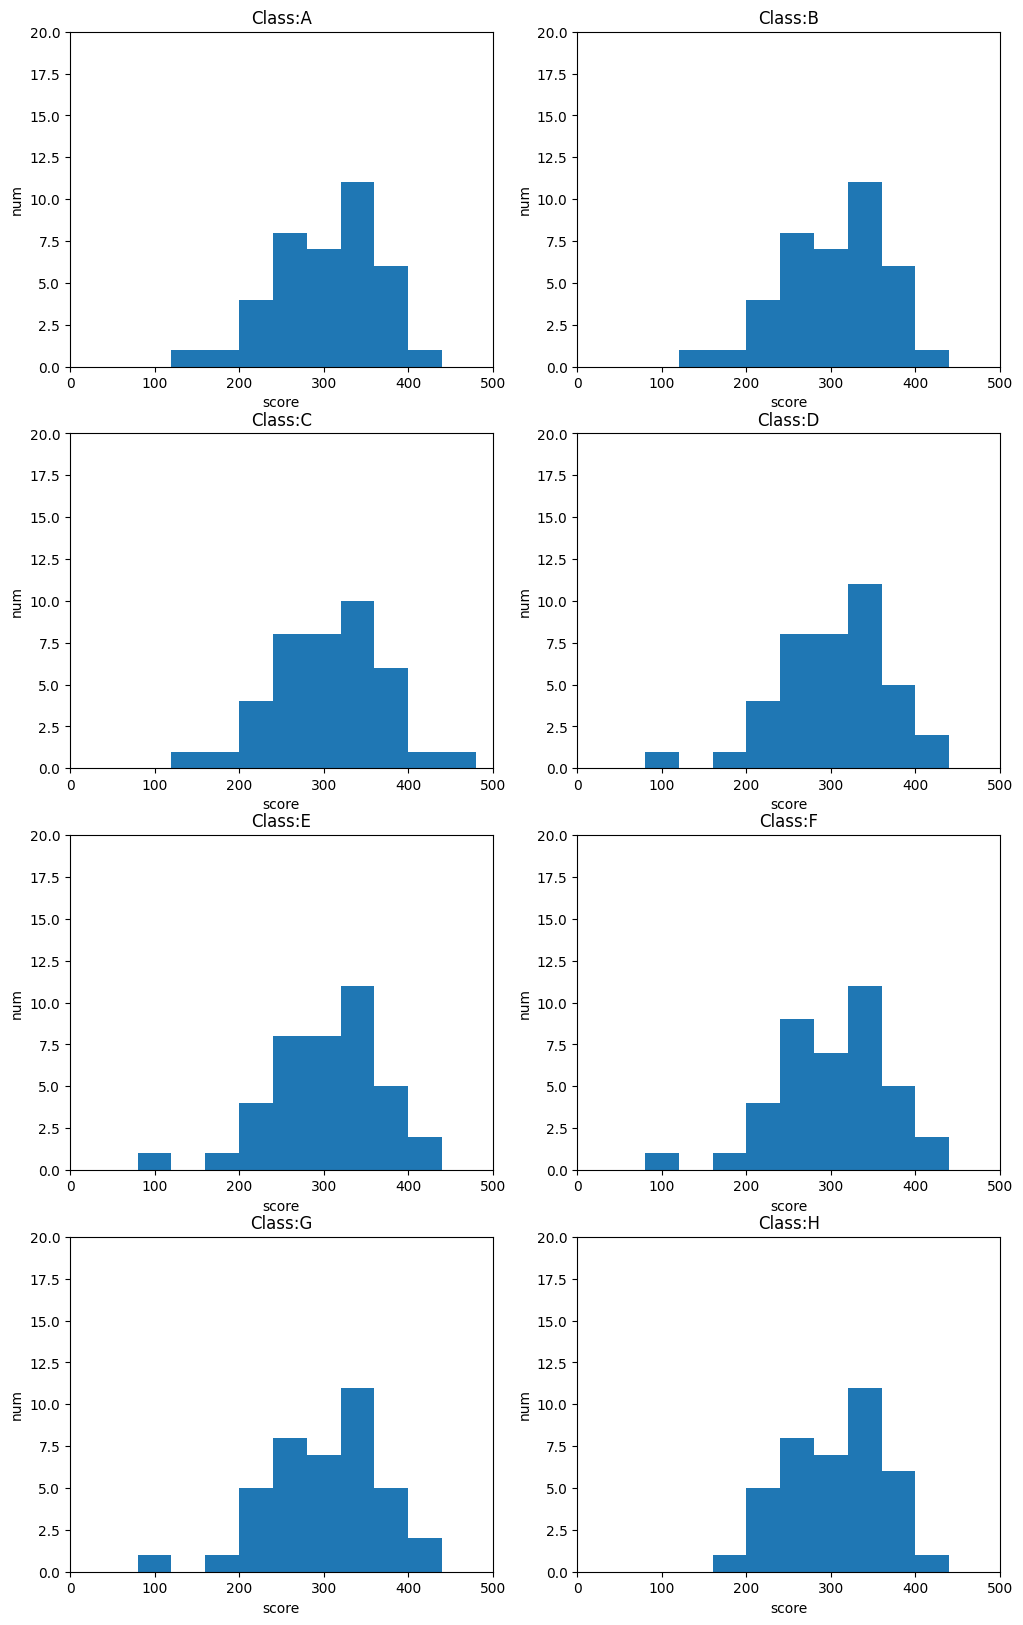

In [59]:
# 初期クラス編成のテストスコアの分布を確認
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(C):
    cls_df = s_df.loc[s_df["init_assigned_class"] == c, :]
    ax = fig.add_subplot(4, 2, i + 1, xlabel="score", ylabel="num", xlim=(0, 500), ylim=(0, 20),
                         title=f"Class:{c}")
    ax.hist(cls_df["score"], bins=range(0, 500, 40))

一度求解（solve）しているので、モデルを再定義する

In [60]:
prob = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)

# 生徒のリスト
S = s_df["student_id"].tolist()
# クラスのリスト
C = ["A", "B", "C", "D", "E", "F", "G", "H"]  # 本来ハードコーディングは望ましくない
# 生徒とクラスのペアのリスト（取りうる全組み合わせ318人×8クラス＝2544通り）
SC = [(s, c) for s in S for c in C]

# 生徒をどのクラスに割り当てるかを変数として定義
x = pulp.LpVariable.dicts("x", SC, cat="Binary")
# 第2引数は変数の添え字のリスト

# 1. 各生徒は1つのクラスに割り当たる
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1

# 2. 各クラスの生徒の人数は39人以上40人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <= 40

# 男子生徒のリスト
S_male = s_df.loc[s_df["gender"] == 1, "student_id"].tolist()
# 女子生徒のリスト
S_female = s_df.loc[s_df["gender"] == 0, "student_id"].tolist()
# 3. 各クラスの男子、女子の人数は20人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = s_df.set_index("student_id").to_dict()["score"]
# 平均点の算出
score_mean = s_df["score"].mean()
# 4. 各クラスの学力試験の平均点は学年平均±10点とする
# score_mean - 10 <= クラスのスコア合計÷クラスの人数
# クラスのスコア合計÷クラスの人数 <= score_mean + 10
# をそれぞれ通分する。
for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) <= pulp.lpSum([x[s, c] * score[s] for s in S])
    prob += pulp.lpSum([x[s, c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s, c] for s in S])

# リーダー気質の生徒の集合
S_leader = s_df.loc[s_df["leader_flag"] == 1, "student_id"].tolist()
# 5. 各クラスにリーダー気質の生徒を2人以上割り当てる
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = s_df.loc[s_df["support_flag"] == 1, "student_id"].tolist()
# 6. 特別な支援が必要な生徒は各クラスに1人以下とする
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_support]) <= 1

# 7. 特別ペアの生徒は同一クラスに割り当てない
for s in s_pair_df.itertuples():
    for c in C:
        prob += x[s.student_id1, c] + x[s.student_id2, c] <= 1

# 目的関数：初期クラス編成とできるだけ一致させる
prob += pulp.lpSum([x[s, c] * init_flag[s, c] for s, c in SC])

status = prob.solve(pulp.PULP_CBC_CMD(msg=0))
print(status)  # 1 = Optimal

1


In [61]:
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]

for c, Ss in C2Ss.items():
    print("Class:", c)
    print("Num:", len(Ss))
    print("Student:", Ss)
    print()

Class: A
Num: 40
Student: [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]

Class: B
Num: 39
Student: [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203, 234, 235, 240,

In [63]:
# 検証用データフレームの用意
result_df2 = s_df.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {s: c for s in S for c in C if x[s, c].value() == 1}

# 生徒データに各生徒がどのクラスに割り当てられたかの情報を結合
result_df2["assigned_class"] = result_df2["student_id"].map(S2C)

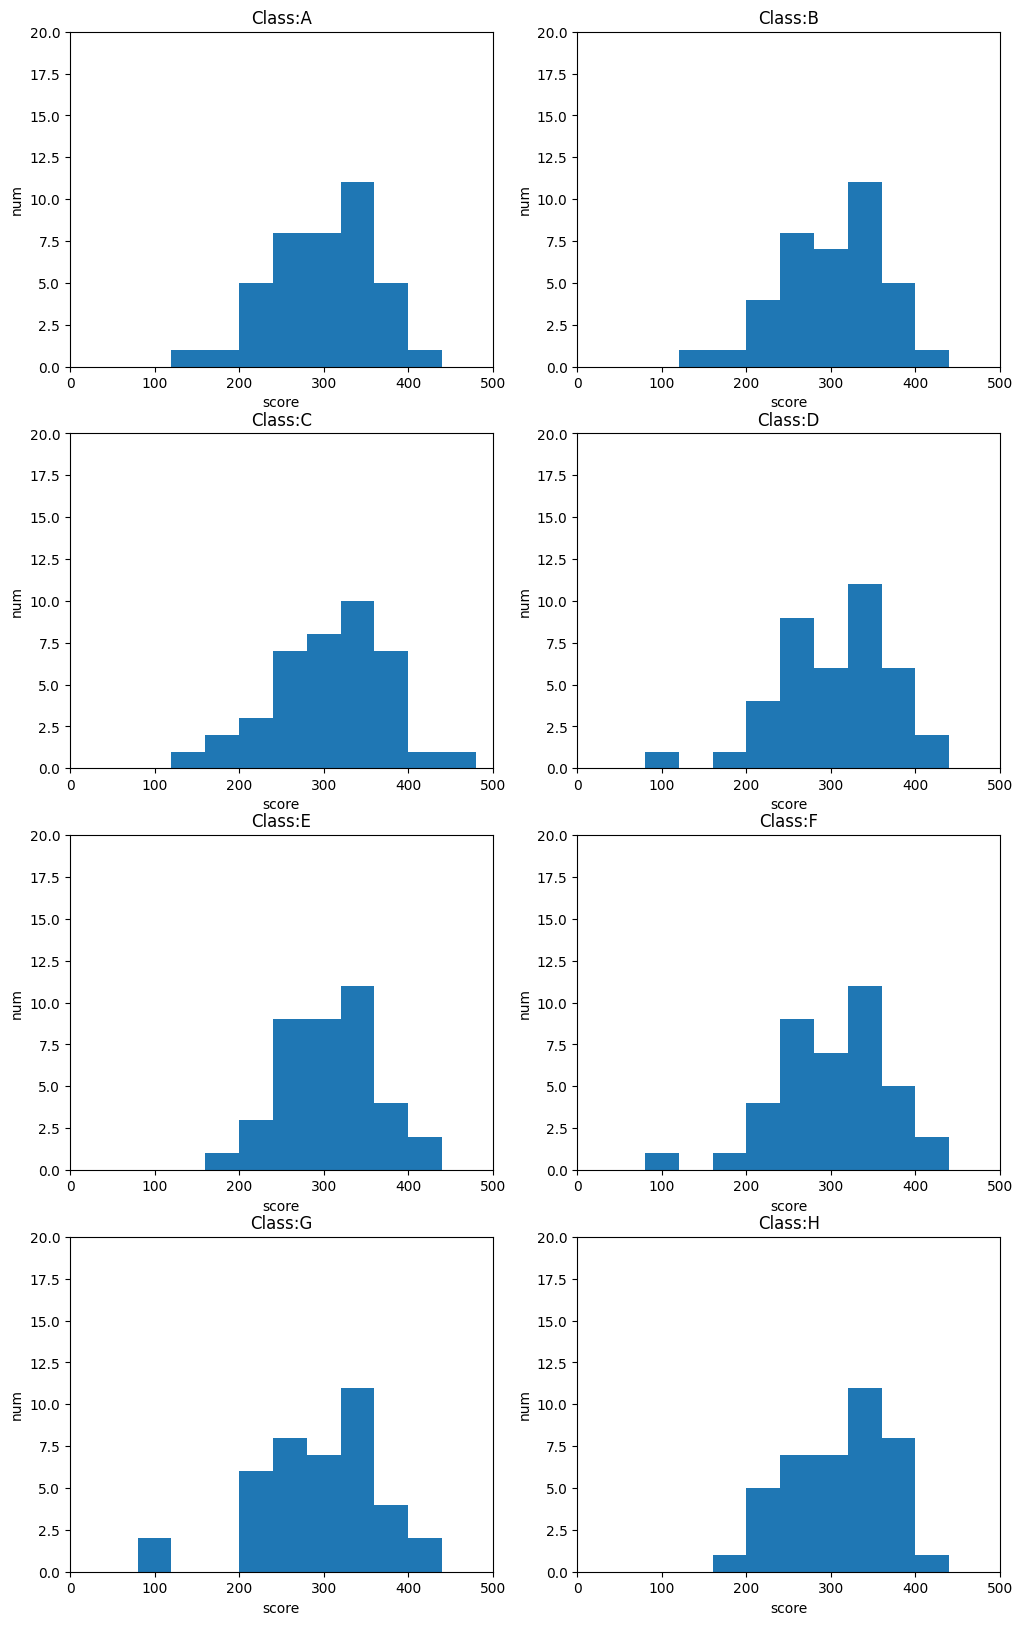

In [64]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(C):
    cls_df = result_df2.loc[result_df2["assigned_class"] == c, :]
    ax = fig.add_subplot(4, 2, i + 1, xlabel="score", ylabel="num", xlim=(0, 500), ylim=(0, 20),
                         title=f"Class:{c}")
    ax.hist(cls_df["score"], bins=range(0, 500, 40))